In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from gas.PDFs.RDFs import RDF, quick_rdf


In [3]:
if cp.cuda.is_available():
    print(f"Found {cp.cuda.runtime.getDeviceCount()} GPUs")
    device = 0
    print(f"Will use GPU {device}")
    cp.cuda.Device(device).use()
else:
    print("No GPUs found, using CPU")
    device='cpu'

Found 4 GPUs
Will use GPU 0


# a Ta

In [4]:
file_Ta = Path("/home/arthur/Data/PDFs/structures/a_Ta/Ta_sim_model.xyz")
assert file_Ta.exists()
material = "a_Ta"
pbcs = [1,1,1]

In [5]:
class atoms: pass

# Define a generator function to access specific rows in the coordinate text file
def generate_specific_rows(filePath, userows=[]):
    with open(filePath, 'rb') as f:
        for i, line in enumerate(f):
            if i in userows:
                yield line

# Get cell dimensions from 2nd row of the coordinate file.  File uses Prismatic input format: https://prism-em.com/docs-inputs/
atoms.cell = np.eye(3) * np.loadtxt(
    generate_specific_rows(
        file_Ta,
        userows = [1]),
    unpack='true',
)

# Read in all atomic coordinates, and then keep only (x,y,z) coordinates.
atoms.positions = np.genfromtxt(
    file_Ta,
    skip_header=2,
    skip_footer=2,
)[:,1:4]

print(f"total atoms: {atoms.positions.shape[0]}")

total atoms: 1023999


## GPU 

Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 20 A
Num total atoms in sim = 1023999
atomic density = 0.0528 atoms / A^3
-- done --
Total time (h:m:s) 0:00:05.797
Center atoms per sec: 176_653.02



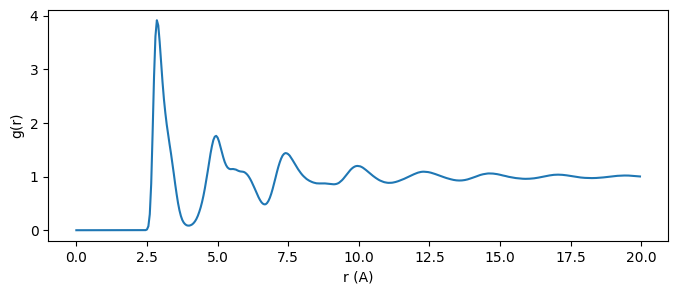

In [6]:
### The main variable here is batch_size, I have found that 25k is the roughly optimal
### value for my GPU. If running out of memory, decrease batch_size,
### if things are slow, increase skip
### For me, runs with skip=1, r_max=20 in ~ 4.6 seconds, ~225k centers/second

batch_size = 25_000

dr = 0.05
hist_r_max = 20
skip = 1

rdf = RDF(device=device, v=1)
r, gr = rdf.rdf(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    batch_size= batch_size,
    reduced=True,
)
r, gr = r.get(), gr.get()

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()


## CPU 

In [7]:
device = 'cpu'

Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 20 A
starting KD Tree
KDTree calc time: 3.2e+00 s
Num total atoms in sim = 1023999
Skip = 100, so calculating using 10240 atoms as centers


100%|██████████| 10240/10240 [00:02<00:00, 3446.37it/s]


-- done --
Total time (h:m:s) 0:00:06.191
Center atoms per sec: 1654.1



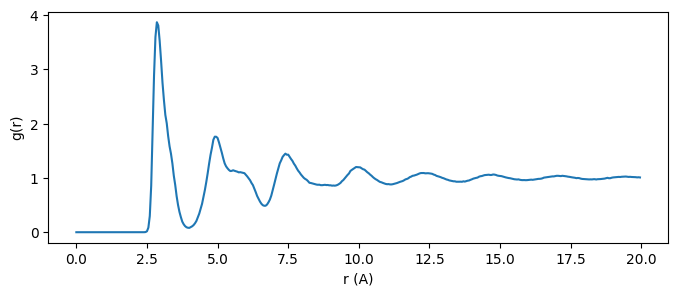

In [8]:
### here using a KDtree search, generally better for larger radii and fewer centers
### set "skip" to sample the centerpoints used

dr = 0.05
hist_r_max = 20
skip = 100

rdf = RDF(device=device, v=1)
r, gr = rdf.rdf_cpu(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    reduced=True,
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()


100%|██████████| 10240/10240 [00:01<00:00, 5498.42it/s]


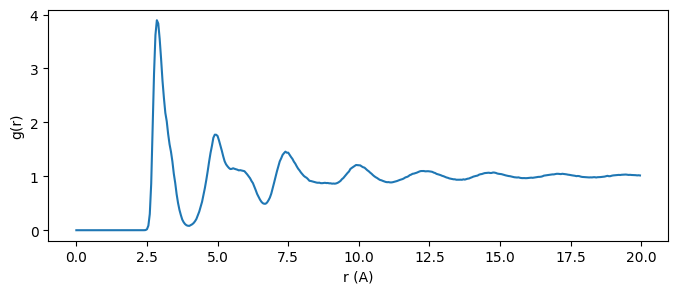

In [9]:
### here using a volumetric search, faster in other cases

dr = 0.05
hist_r_max = 20
skip = 100

r, Gr, gr = quick_rdf(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()
